Study the electricity demand from clients in Portugal, during 2013 and 2014. 

 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed. The data file has been provided with this assignment. It is also available at the links provided above.

In [ ]:
#pathToFile = r"C:\\path\\to\\file\\"
pathToFile = r"C:\\Users\\zoexu\\Downloads\\Data Science 4\\assignment2-data\\assignment2-data\\"

fileName = 'LD2011_2014.txt'

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [ ]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [ ]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [ ]:
data.head(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.tail(2)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-03-23 02:00:00,1.269036,17.780939,1.737619,111.788618,54.878049,142.857143,3.957038,161.616162,45.454545,48.387097,...,172.733762,22600.0,831.223629,1090.909091,16.949153,7.02165,489.903424,48.414023,706.744868,17621.621622
2014-03-23 02:15:00,1.269036,17.780939,1.737619,115.853659,47.560976,145.833333,3.957038,164.983165,40.209790,46.236559,...,167.023555,22200.0,797.468354,1045.454545,15.645372,4.68110,444.249342,53.422371,717.008798,16216.216216


In [ ]:
data.shape

(113001, 370)

#### As it can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113001 entries, 2011-01-01 00:15:00 to 2014-03-23 02:15:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(369), int64(1)
memory usage: 319.4+ MB


In [ ]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000,...,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000,113001.000000
mean,3.827692,19.289851,3.210785,74.060356,34.640833,132.814907,4.146944,177.603446,37.776911,39.394104,...,199.010120,33946.701357,1775.366164,2717.364126,59.479127,8.706733,383.304618,87.742380,576.274271,6303.302697
std,5.934946,14.103330,12.251834,59.832762,27.628810,104.386895,6.409235,129.508354,31.810050,34.454423,...,202.620770,37723.642484,1854.115023,2743.227931,66.424159,10.072235,285.000108,81.422590,403.242015,8484.188906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.269036,23.470839,1.737619,81.300813,37.804878,151.785714,2.826456,212.121212,38.461538,37.634409,...,119.914347,19600.000000,962.025316,1954.545455,20.860495,6.436513,493.415277,63.439065,741.202346,0.000000
75%,2.538071,29.871977,1.737619,109.756098,53.658537,205.357143,4.522329,279.461279,55.944056,61.290323,...,389.721627,50800.000000,3223.628692,4840.909091,104.302477,11.117613,615.452151,148.580968,867.302053,15221.621622
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,41.266252,552.188552,157.342657,198.924731,...,849.393291,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1130.816506,360.601002,1463.343109,29254.054054


### Plot the first 2 days of 2012 for the first 2 clients

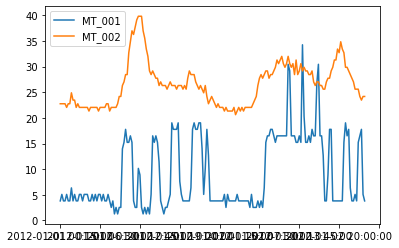

In [ ]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We  note that the main difference between the curves is the level (also seen on the means in df.describe()).  We know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with low number of clients having zero demand

In [ ]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [ ]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
81.09375


In [ ]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
2


In [ ]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

MemoryError: Unable to allocate 121. MiB for an array with shape (369, 42825) and data type float64

## Getting average curves per client

In [ ]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [ ]:
data['hour'] = data.index.map(lambda x: x[11:])

In [ ]:
data.head(3)

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370,hour
2013-01-01 00:15:00,2.538071,22.759602,2.606429,138.211382,63.414634,255.952381,4.522329,239.057239,57.692308,78.494624,...,22300.0,886.075949,1000.000000,16.949153,6.436513,616.330114,76.794658,731.671554,8086.486486,00:15:00
2013-01-01 00:30:00,1.269036,22.759602,2.606429,138.211382,63.414634,264.880952,5.652911,228.956229,57.692308,76.344086,...,21000.0,864.978903,909.090909,18.252934,3.510825,564.530290,76.794658,727.272727,8086.486486,00:30:00
2013-01-01 00:45:00,2.538071,22.759602,2.606429,134.146341,60.975610,250.000000,5.652911,239.057239,54.195804,76.344086,...,18200.0,860.759494,840.909091,16.949153,5.851375,590.869183,68.447412,730.205279,7848.648649,00:45:00


### Getting average curves per client

In [ ]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

MemoryError: Unable to allocate 121. MiB for an array with shape (369, 42825) and data type float64

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [ ]:
average_curves_norm = average_curves/(average_curves.mean())

NameError: name 'average_curves' is not defined

#### Plot the first 2 and last 2 clients

In [ ]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

NameError: name 'average_curves_norm' is not defined

## Clustering Analysis on the average normalized curves

In [ ]:
X = average_curves_norm.copy()  # We call this normalized curve
X = np.array(X.T) # put it on the right format

NameError: name 'average_curves_norm' is not defined

a. Determine what a convenient number of clusters. Justify your choice.  Make use of the sklearn's package for k-means for this. You may refer to the module to figure out how to come up with the optimal number of clusters. 

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the center of the cluster (make this curve thicker to distinguish it from the individual curves).  The center is also sometimes referred to as "centroid".

In [ ]:
client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 

In [ ]:
pip install linear_algebra

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement linear_algebra
ERROR: No matching distribution found for linear_algebra


In [ ]:
from linear_algebra import squared_distance, vector_mean, distance
import math, random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'linear_algebra'

a. Determine the optimal value of k ( number of clusters).

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b).  The cells below are only to give you a headstart.  You may or may not use these and come up with your own interpretation.


In [ ]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [ ]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

Continue with your analysis here: